Today we are going to look at another couple of meteorology packages: awips-python and Py-ART.

Awips-python is a python extension to the AWIPS meteorology program. This package contains routines to grab many different kinds of data: METAR observations, radar data, model data, etc. from real time and plot it for use! Currently if you follow our Twitter account (shamless plug) @UMLWeatherCTR, you will see that we plot temperatures for the New England region 3 times a day. We do this using awips-python!

Py-ART is a python package which allows us to plot NEXRAD Level 2 and 3 files in python! We can do many different kinds of plots: range, ppi, radar, etc. as well as being able to stitch together multiple radar sites into one plot!

Let's start with looking at awips-python

In [ ]:
pip install python-awips

For this notebook, we are going to focus on METAR station observations and looking at how we can define them for a specific region.

In [1]:
#Import all the necessary packages
from awips.dataaccess import DataAccessLayer
from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange
import numpy as np
import cartopy.crs as ccrs
import warnings
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
from shapely.geometry import Polygon
from metpy.plots import StationPlot
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pytz
from datetime import datetime, timedelta


# EDEX request for a single state
#We need to connect to the EDEX server to grab the data
edexServer = "edex-cloud.unidata.ucar.edu"
DataAccessLayer.changeEDEXHost(edexServer)

#We need to tell it what kind of data we want
#First we want to grab map data for the area that we are going to plot. Let's get data for Massachusetts
#To do this, we first set the request that we want
request = DataAccessLayer.newDataRequest('maps')
request.addIdentifier('table', 'mapdata.states')
request.addIdentifier('state', 'MA')
request.addIdentifier('geomField', 'the_geom')
request.setParameters('state','name','lat','lon')

#Now that the request is set, we want to send it to the EDEX server.
response = DataAccessLayer.getGeometryData(request)
record = response[0]
#Print out the record to make sure we found it
print("Found " + str(len(response)) + " MultiPolygon")

#Now get the relevant information from the record.
#Make sure it is the correct state and get it's lat and lon.
#Then get the lat and lon for the bounds (south west and northeast corners of the state)
state={}
state['name'] = record.getString('name')
state['state'] = record.getString('state')
state['lat'] = record.getNumber('lat')
state['lon'] = record.getNumber('lon')
#state['geom'] = record.getGeometry()
state['bounds'] = record.getGeometry().bounds

#Print out all the information to make sure we got the correct stuff
print(state['name'], state['state'], state['lat'], state['lon'], state['bounds'])
print()

Found 1 MultiPolygon
Massachusetts MA 42.25788 -71.81423 (-73.50799560499996, 41.23796463000008, -69.92780303999996, 42.88691330000006)



Now that we have map data for Massachusetts, let's plot it to make sure it looks right!

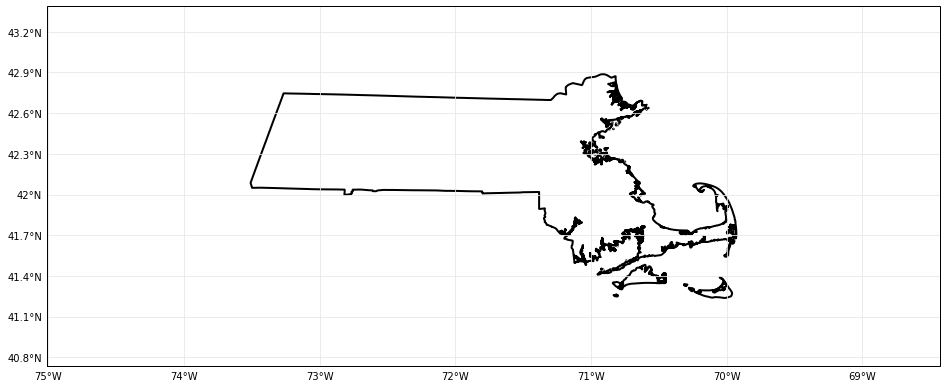

In [2]:
def make_map(bbox, proj=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(16,12),subplot_kw=dict(projection=proj))
    ax.set_extent(bbox)
    gl = ax.gridlines(draw_labels=True, color='#e7e7e7')
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

# buffer our bounds by +/i degrees lat/lon. 
#This lets us set a box of lat/lon values that we want to display the data in
bounds = state['bounds']
bbox=[bounds[0]-1.5,bounds[2]+1.5,bounds[1]-0.5,bounds[3]+0.5]

#Make the figure
fig, ax = make_map(bbox=bbox)
#We are using a shape feature in cartopy so we will create it here
#This is similar to how we 
shape_feature = ShapelyFeature(record.getGeometry(),ccrs.PlateCarree(),
                    facecolor='none', linestyle="-",edgecolor='#000000',linewidth=2)
#Now we need to add the feature to the map
ax.add_feature(shape_feature)

This method will work for any state, so long as we tell the program which state we want the data for.

Let's try and get data for multiple states. Luckily, we have the multipolygon class feature, so we can grab info for multiple states and save them to a list

Found 8 MultiPolygons
Connecticut CT 41.62196 -72.72623
Massachusetts MA 42.25788 -71.81423
Maine ME 45.38046 -69.22999
New Jersey NJ 40.20049 -74.66876
New York NY 42.94796 -75.51491
Vermont VT 44.07511 -72.66273
New Hampshire NH 43.68556 -71.57754
Rhode Island RI 41.67544 -71.55579


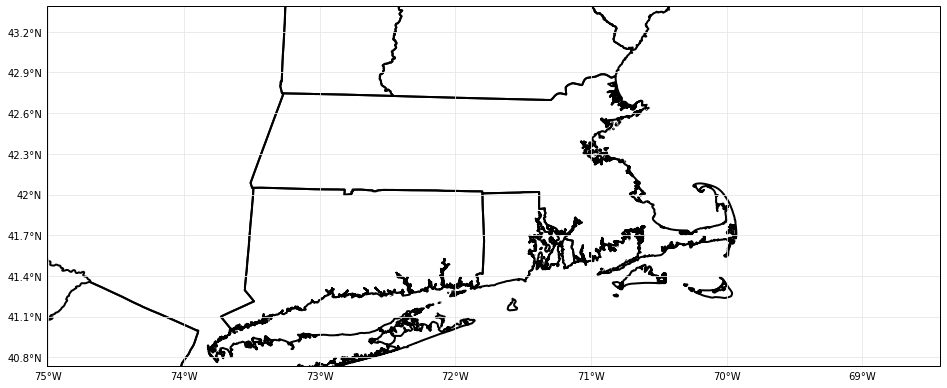

In [3]:
# EDEX request for multiple states
request = DataAccessLayer.newDataRequest('maps')
request.addIdentifier('table', 'mapdata.states')
request.addIdentifier('geomField', 'the_geom')
request.addIdentifier('inLocation', 'true')
request.addIdentifier('locationField', 'state')
request.setParameters('state','name','lat','lon')
request.setLocationNames('MA','CT','VT','NH','ME','RI','NY','NJ')
response = DataAccessLayer.getGeometryData(request)
print("Found " + str(len(response)) + " MultiPolygons")

# Append each geometry to a numpy array
states = np.array([])
for ob in response:
    print(ob.getString('name'), ob.getString('state'), ob.getNumber('lat'), ob.getNumber('lon'))
    states = np.append(states,ob.getGeometry())
    
def make_map(bbox, proj=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(16,12),subplot_kw=dict(projection=proj))
    ax.set_extent(bbox)
    gl = ax.gridlines(draw_labels=True, color='#e7e7e7')
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

# buffer our bounds by +/i degrees lat/lon
bounds = state['bounds']
bbox=[bounds[0]-1.5,bounds[2]+1.5,bounds[1]-0.5,bounds[3]+0.5]

fig, ax = make_map(bbox=bbox)
shape_feature = ShapelyFeature(states,ccrs.PlateCarree(),
                    facecolor='none', linestyle="-",edgecolor='#000000',linewidth=2)
ax.add_feature(shape_feature)

Now that we have our map data, we can look at some METAR observations for the area.

First we need to create an envelope (a bounding box for the data) to tell the program we want data for a specfic area only. If we didn't create this envelope, the program would grab the data for the whole of the Unite States, which is over tens of thousands of points!

After creating this envelope we will begin to set up our request for data from the EDEX server.

In [4]:
# Create envelope geometry
#We will use the bounding box we create earlier to make the bounds
envelope = Polygon([(bbox[0],bbox[2]),(bbox[0],bbox[3]),
                    (bbox[1], bbox[3]),(bbox[1],bbox[2]),
                    (bbox[0],bbox[2])])

# New obs request
#Now we will request the observations
DataAccessLayer.changeEDEXHost(edexServer)

#Notice here that we use the string "obs" for the newDataRequest
#If you look back above, we previously used the string "map" to get the map data
#There are many data types available to us. The full list is:
# "obs", "satellite", "map", "radar", "warning", "grid", and "binlightning"
request = DataAccessLayer.newDataRequest("obs", envelope=envelope)
availableProducts = DataAccessLayer.getAvailableParameters(request)
print(availableProducts)

['dewpoint', 'precip3Hour', 'sunshine', 'windGust', 'latitude', 'autoStationType', 'windDir', 'pkwndTime', 'maxTemp24Hour', 'snowWater', 'reportType', 'pkwndDir', 'snowDepth', 'vertVisibility', 'wmoId', 'skyCover', 'temperature', 'stationName', 'windSpeed', 'timeObs', 'longitude', 'stationId', 'elevation', 'snowfall6Hour', 'seaLevelPress', 'skyCoverGenus', 'forecastHr', 'minTemp24Hour', 'refTime', 'visibility', 'maxTemp6Hour', 'dataURI', 'windDirStr', 'precip24Hour', 'presWeather', 'pkwndSpeed', 'precip6Hour', 'skyLayerBase', 'tempFromTenths', 'rawMETAR', 'altimeter', 'precip1Hour', 'pressChange3Hour', 'correction', 'dpFromTenths', 'pressChangeChar', 'skyCoverType', 'minTemp6Hour']


Above is listed all the variables we can pull from the available METAR obs files. Some of these have yet to be programmed into the actual awips-python, but we can go into the code and add them ourselves.

Here are the available parameters:
single_value_params = ["timeObs", "stationName", "longitude", "latitude",
                       "temperature", "dewpoint", "windDir",
                       "windSpeed", "seaLevelPress"]
multi_value_params = ["presWeather", "skyCover", "skyLayerBase"]

That's a pretty good list of parameters, but what if we wanted the windGust or pkwndSpeed? We need to look at the source code for the DataAccessLayer.getMetarObs file and see what it looks like:



def getMetarObs(response):
    """
    Processes a DataAccessLayer "obs" response into a dictionary,
    with special consideration for multi-value parameters
    "presWeather", "skyCover", and "skyLayerBase".

    Args:
            response: DAL getGeometry() list

    Returns:
            A dictionary of METAR obs
    """
    from datetime import datetime
    single_val_params = ["timeObs", "stationName", "longitude", "latitude",
                         "temperature", "dewpoint", "windDir",
                         "windSpeed", "seaLevelPress"]
    multi_val_params = ["presWeather", "skyCover", "skyLayerBase"]
    params = single_val_params + multi_val_params
    station_names, pres_weather, sky_cov, sky_layer_base = [], [], [], []
    obs = dict({params: [] for params in params})
    for ob in response:
        avail_params = ob.getParameters()
        if "presWeather" in avail_params:
            pres_weather.append(ob.getString("presWeather"))
        elif "skyCover" in avail_params and "skyLayerBase" in avail_params:
            sky_cov.append(ob.getString("skyCover"))
            sky_layer_base.append(ob.getNumber("skyLayerBase"))
        else:
            # If we already have a record for this stationName, skip
            if ob.getString('stationName') not in station_names:
                station_names.append(ob.getString('stationName'))
                for param in single_val_params:
                    if param in avail_params:
                        if param == 'timeObs':
                            obs[param].append(datetime.fromtimestamp(ob.getNumber(param) / 1000.0))
                        else:
                            try:
                                obs[param].append(ob.getNumber(param))
                            except TypeError:
                                obs[param].append(ob.getString(param))
                    else:
                        obs[param].append(None)

                obs['presWeather'].append(pres_weather)
                obs['skyCover'].append(sky_cov)
                obs['skyLayerBase'].append(sky_layer_base)
                pres_weather = []
                sky_cov = []
                sky_layer_base = []
    return obs
    
    
Notice that inside the getMetarObs that the same single_value_params and multi_value_params lists as we used in our program are identified! That means, even if we tell the program we want data outside of these values, it will not give it to us since the function getMetarObs isn't looking for that data. 

We can fix this by adding the getMetarObs function into our code and modifying it as seen below

In [9]:
def getMetarObs_new(response):
    """
    Processes a DataAccessLayer "obs" response into a dictionary,
    with special consideration for multi-value parameters
    "presWeather", "skyCover", and "skyLayerBase".

    Args:
            response: DAL getGeometry() list

    Returns:
            A dictionary of METAR obs
    """
    from datetime import datetime
    
    ##HERE WE NEED TO ADD IN THE EXTRA PARAMETERS WE WANT THE PROGRAM TO LOOK FOR
    ##Since we import getMetarObs to begin with, we will rename this function to getMetarObs_new and call it instead
    
    single_val_params = ["timeObs", "stationName", "longitude", "latitude",
                         "temperature", "dewpoint", "windDir",
                         "windSpeed", "seaLevelPress",'windGust','pkwindSpeed']
    multi_val_params = ["presWeather", "skyCover", "skyLayerBase"]
    params = single_val_params + multi_val_params
    station_names, pres_weather, sky_cov, sky_layer_base = [], [], [], []
    obs = dict({params: [] for params in params})
    for ob in response:
        avail_params = ob.getParameters()
        if "presWeather" in avail_params:
            pres_weather.append(ob.getString("presWeather"))
        elif "skyCover" in avail_params and "skyLayerBase" in avail_params:
            sky_cov.append(ob.getString("skyCover"))
            sky_layer_base.append(ob.getNumber("skyLayerBase"))
        else:
            # If we already have a record for this stationName, skip
            if ob.getString('stationName') not in station_names:
                station_names.append(ob.getString('stationName'))
                for param in single_val_params:
                    if param in avail_params:
                        if param == 'timeObs':
                            obs[param].append(datetime.fromtimestamp(ob.getNumber(param) / 1000.0))
                        else:
                            try:
                                obs[param].append(ob.getNumber(param))
                            except TypeError:
                                obs[param].append(ob.getString(param))
                    else:
                        obs[param].append(None)

                obs['presWeather'].append(pres_weather)
                obs['skyCover'].append(sky_cov)
                obs['skyLayerBase'].append(sky_layer_base)
                pres_weather = []
                sky_cov = []
                sky_layer_base = []
    return obs

In [11]:
single_value_params = ["timeObs", "stationName", "longitude", "latitude",
                       "temperature", "dewpoint", "windDir",
                       "windSpeed", "seaLevelPress","windGust","pkwndSpeed"]
multi_value_params = ["presWeather", "skyCover", "skyLayerBase"]
params = single_value_params + multi_value_params
request.setParameters(*(params))

# Time range
lastHourDateTime = datetime.utcnow() - timedelta(minutes = 60)
start = lastHourDateTime.strftime('%Y-%m-%d %H:%M:%S')
end = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')

beginRange = datetime.strptime( start , "%Y-%m-%d %H:%M:%S")
endRange = datetime.strptime( end , "%Y-%m-%d %H:%M:%S")
timerange = TimeRange(beginRange, endRange)
# Get response
response = DataAccessLayer.getGeometryData(request,timerange)
# function getMetarObs was added in python-awips 18.1.4
obs = getMetarObs_new(response)
print(obs)

{'timeObs': [datetime.datetime(2019, 11, 21, 12, 15), datetime.datetime(2019, 11, 21, 12, 15), datetime.datetime(2019, 11, 21, 12, 15), datetime.datetime(2019, 11, 21, 12, 15), datetime.datetime(2019, 11, 21, 12, 17), datetime.datetime(2019, 11, 21, 12, 18), datetime.datetime(2019, 11, 21, 12, 45), datetime.datetime(2019, 11, 21, 12, 45), datetime.datetime(2019, 11, 21, 12, 45), datetime.datetime(2019, 11, 21, 12, 51), datetime.datetime(2019, 11, 21, 12, 51), datetime.datetime(2019, 11, 21, 12, 51), datetime.datetime(2019, 11, 21, 12, 51), datetime.datetime(2019, 11, 21, 12, 51), datetime.datetime(2019, 11, 21, 12, 51), datetime.datetime(2019, 11, 21, 12, 51), datetime.datetime(2019, 11, 21, 12, 51), datetime.datetime(2019, 11, 21, 12, 51), datetime.datetime(2019, 11, 21, 12, 51), datetime.datetime(2019, 11, 21, 12, 53), datetime.datetime(2019, 11, 21, 12, 52), datetime.datetime(2019, 11, 21, 12, 52), datetime.datetime(2019, 11, 21, 12, 53), datetime.datetime(2019, 11, 21, 12, 53), dat

Now that the windGust and pkwndSpeed data are available, we can plot it! Let's plot the windGust for now.

To do this, we need to define the tiem range we want to look for the data for. Looking at our above output, we can see a list of datetime.datetime variables that tells us the available times for the data we are looking for. We can input those, or we can just take the data for the last hour.

In [15]:
#Set the time for the last 12 hours of data
lastHourDateTime = datetime.utcnow() - timedelta(minutes = 720)
start = lastHourDateTime.strftime('%Y-%m-%d %H:%M:%S')
end = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')

beginRange = datetime.strptime( start , "%Y-%m-%d %H:%M:%S")
endRange = datetime.strptime( end , "%Y-%m-%d %H:%M:%S")
timerange = TimeRange(beginRange, endRange)
# Get response
response = DataAccessLayer.getGeometryData(request,timerange)
obs = getMetarObs_new(response)
print("Found " + str(len(response)) + " records")
print("Using " + str(len(obs['windGust'])) + " wind Gust records")

Found 12000 records
Using 69 wind Gust records


TextCollection

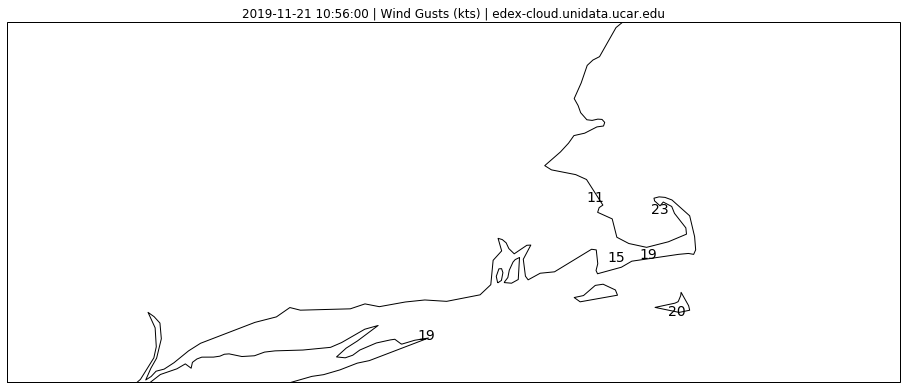

In [16]:
#Now let's plot the data!
#We need to put the data into a dictionary that will hold it until we plot it
data = dict()
#Grab the latitude, and longitude for each data point.
lats = obs['latitude']
lons = obs['longitude']

fig, ax = plt.subplots(figsize=(16,12),subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.set_extent(bbox)
ax.coastlines(resolution='50m')
ax.set_title(str(response[-1].getDataTime()) + " | Wind Gusts (kts) | " + edexServer)

# Suppress nan masking warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

#Grab the data we need
wndgust = np.array(obs['windGust'], dtype=float)
wndgust[wndgust == -9999.0] = 'nan'

stationplot = StationPlot(ax, lons, lats, transform=ccrs.PlateCarree(),
                          fontsize=14)
stationplot.plot_parameter('C', wndgust, color='black')

There's not much in the way of wind Gust data available today, so let's look at air temperature instead!

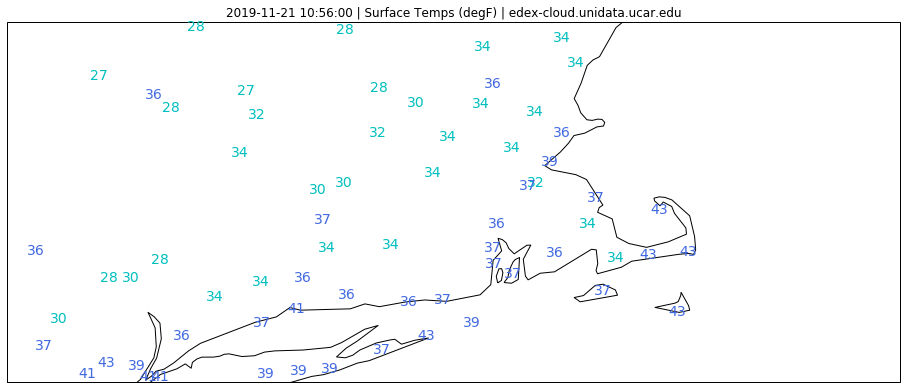

In [22]:
import cartopy.feature as cfeature
#Grab the lat/lon data
lats = obs['latitude']
lons = obs['longitude']

#Set threshold colors for different temperature values to better read the map
thresholds = {
    '15': 'purple',
    '25': 'c',
    '35': 'royalblue',
    '45': 'darkgreen',
    '55': 'green',
    '65': 'y',
    '75': 'orange',
    '85': 'red'
}

fig, ax = plt.subplots(figsize=(16,12),subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.set_extent(bbox)
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.STATES)
ax.set_title(str(response[-1].getDataTime()) + " | Surface Temps (degF) | " + edexServer)

# Suppress nan masking warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

for x, value in thresholds.items():
    tair = np.array(obs['temperature'], dtype=float)
    tair[tair == -9999.0] = 'nan'
    tair = (tair*1.8)+32
    if x==max(thresholds):
        tair[(tair < int(x))] = 'nan'
    elif x==min(thresholds):
        tair[(tair >= int(x)+10)] = 'nan'
    else:
        tair[(tair < int(x))] = 'nan'
        tair[(tair >= int(x)+10)] = 'nan'

    stationplot = StationPlot(ax, lons, lats, transform=ccrs.PlateCarree(),
                          fontsize=14)
    stationplot.plot_parameter('C', tair, color=thresholds[str(x)])


Now let's look at some radar data and how to plot it with pyART.

We can download radar data easily using the Amazon Web Services (AWS) radar data archive. This archive contains level 2 radar data back until 1997 that can be downloaded and easily plotted in python!

In [ ]:
#Install the nexradaws package to be able to access the data
pip install nexradaws
conda install -c conda-forge arm_pyart


In [34]:
#Now let's try downloading some data. Let's look at data for our Halloween Storm from 2011.
#So we need data from 10/29/2011 at 20z

import nexradaws
import pyart
import os

#Open an interface to get the radar data
conn = nexradaws.NexradAwsInterface()

#Put the radar sites here
radarid = 'KBOX'

#Put the year, month, day and start/end hour (z time)
year = '2011'
month = '10'
day = '29'
hourstart = '20'
hourend = '20'

#Make directory to hold radar files
if not os.path.exists('radar_data'):
    os.makedirs('radar_data')
#Create datetime objects for the start time and end time that we want the radar data
start = datetime(int(year),int(month),int(day),int(hourstart),0)
end = datetime(int(year),int(month),int(day),int(hourend),59)

#See if the files exist on the server and if so, download them
#If not, add the date and site to the missing array
try:
    radarid = 'KBOX'
    scans = conn.get_avail_scans_in_range(start, end, radarid)
    localfiles = conn.download(scans[0:],'radar_date')
except:
    pass

Downloaded KBOX20111029_202955_V03.gz
Downloaded KBOX20111029_201822_V03.gz
Downloaded KBOX20111029_201235_V03.gz
Downloaded KBOX20111029_202408_V03.gz
Downloaded KBOX20111029_200648_V03.gz
Downloaded KBOX20111029_200102_V03.gz
Downloaded KBOX20111029_204715_V03.gz
Downloaded KBOX20111029_203542_V03.gz
Downloaded KBOX20111029_204129_V03.gz
Downloaded KBOX20111029_205302_V03.gz
Downloaded KBOX20111029_205849_V03.gz
11 out of 11 files downloaded...0 errors


Now that we have our radar files, we can plot them. Each radar file contains many different parameters to plot (composite reflectivity, base reflectivity, velocity, etc)

Let's plot one of the radar files we downloaded

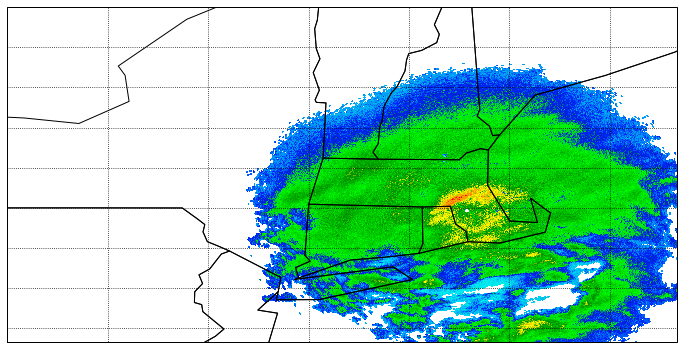

In [69]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap
import numpy as np
import cartopy.feature as cfeature
%matplotlib inline
#Load the first radar file into the radar variable
radar = pyart.io.read_nexrad_archive(localfiles.success[0].filepath)

#Tell the program which radar site we are plotting, we picked KBOX
loc = pyart.io.nexrad_common.get_nexrad_location('KBOX')

#Set the lat and lon of the radar site
lon0 = loc[1] ; lat0 = loc[0]

#Set the figure for plotting
figure = plt.figure(figsize=(12,8))
axes = figure.add_subplot(111,projection=ccrs.PlateCarree())

#Set up the basemap grid to get the lat/lon field
m = Basemap(projection='lcc',lon_0=-73,lat_0=42.5,
          llcrnrlat=40,llcrnrlon=-78,
          urcrnrlat=45,urcrnrlon=-68,resolution='l')

#set up the plotting grid for the data
display = pyart.graph.RadarMapDisplay(radar)
x,y = display._get_x_y(0,True,None)
axes.set_extent([-78, -68, 40, 45], ccrs.Geodetic())
axes.gridlines(color="black", linestyle="dotted")
axes.coastlines()
axes.add_feature(cfeature.STATES)

#get the plotting grid into lat/lon coordinates
x0,y0 = m(lon0,lat0)
glons,glats = m((x0+x*1000.), (y0+y*1000.),inverse=True)

#read in the lowest scan angle reflectivity field in the NEXRAD file
refl = np.squeeze(radar.get_field(sweep=0,field_name='reflectivity'))
#Set the NWS radar colormap
cmap = 'pyart_NWSRef'
levs = np.linspace(0,80,41,endpoint=True)
norm = matplotlib.colors.BoundaryNorm(levs,256)
#create a colormesh of the reflectivity using with the plot settings defined above
axes.pcolormesh(glons,glats,refl,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
plt.show()